In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,normalized_mutual_info_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, fbeta_score

In [2]:
#Load Data
data_jan=pd.read_csv('Jan_data.csv',index_col=0)
data_feb=pd.read_csv('Feb_data.csv',index_col=0)

In [4]:
#Standard Scalar
def scaling(df):
    df = df.reindex(columns=(list([a for a in df.columns if a != 'is_churn']) +['is_churn'] ))
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:,:-1])
    scaled_data = pd.DataFrame(scaled_data,columns=df.columns[:-1])
    scaled_data['is_churn']=df.is_churn.values.astype(int)
    scaled_data=scaled_data.set_index([df.index])
    return scaled_data


scaled_data_jan=scaling(data_jan)
scaled_data_feb=scaling(data_feb)

y=scaled_data_jan.is_churn
X=scaled_data_jan.drop(columns=['is_churn'])
y_test=scaled_data_feb.is_churn
X_test=scaled_data_feb.drop(columns='is_churn')

#Take test and validation set
test_x, X_Validation, test_y, y_Validation = train_test_split(X_test, y_test, test_size=0.3)

In [3]:
y=data_jan.is_churn
X=data_jan.drop(columns=['is_churn'])
y_test=data_feb.is_churn
X_test=data_feb.drop(columns='is_churn')

#Take test and validation set
test_x, X_Validation, test_y, y_Validation = train_test_split(X_test, y_test, test_size=0.3)

# Learning Curve For Logistic Regression

In [5]:
#Resample multiple times for learning curve
def logloss_resampling(train,train_y, test, test_y,nruns, sampsize):
    
    loglosses = []
    
    #Logistic regression
    my_model = LogisticRegression(solver='lbfgs',max_iter=1000)
    #fit the models and compute logloss on test data
    for i in range(nruns):
        index_list = np.random.randint(0, len(train), size=sampsize)
        train_samp = train.iloc[index_list]
        y_sample = train_y.iloc[index_list]
        my_model.fit(train_samp,y_sample)
        loglosses.append(log_loss(test_y, my_model.predict_proba(test)[:, 1]))
       
    #Returns the mean(logloss) and SE(logloss)
    return np.mean(loglosses),np.std(loglosses,ddof = 1)/np.sqrt(nruns)

In [28]:
linspace = [2**(i) for i in range(10,19)]
lg_mean = np.zeros(len(linspace))
lg_se = np.zeros(len(linspace))

#Run 20 resampling
for i,size in enumerate(linspace):
    lg_mean[i],lg_se[i]= logloss_resampling(X,y,X_Validation,y_Validation,30, size)
    print('For sample size {}, The mean logloss is {}.'.format(size,lg_mean[i]))

For sample size 1024, The mean logloss is 0.3926709493918415.
For sample size 2048, The mean logloss is 0.38133013679665323.
For sample size 4096, The mean logloss is 0.3762267097092184.
For sample size 8192, The mean logloss is 0.3673953463636328.
For sample size 16384, The mean logloss is 0.34799448021336055.
For sample size 32768, The mean logloss is 0.33087159093828616.
For sample size 65536, The mean logloss is 0.3279197047523832.
For sample size 131072, The mean logloss is 0.3218998279342813.
For sample size 262144, The mean logloss is 0.3204230644202687.


Text(0.5, 1.0, 'Mean Logloss and Confidence Interval')

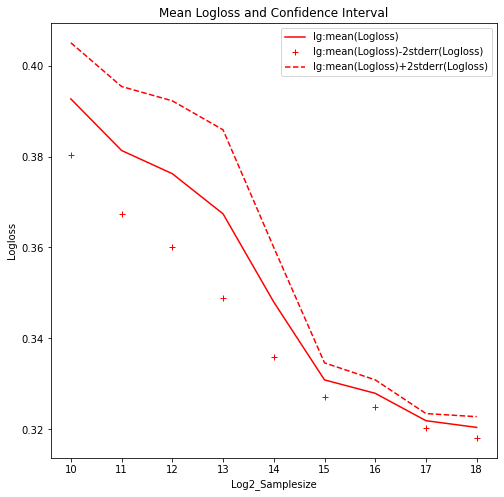

In [29]:
#Make learning curve. plots
plt.figure(figsize = (8,8))
plt.plot(np.log2(linspace),lg_mean,'r',label = 'lg:mean(Logloss)')
plt.plot(np.log2(linspace),lg_mean-2*lg_se,'r+',label = 'lg:mean(Logloss)-2stderr(Logloss)')
plt.plot(np.log2(linspace),lg_mean+2*lg_se,'r--',label = 'lg:mean(Logloss)+2stderr(Logloss)')

plt.legend()
plt.xlabel('Log2_Samplesize')
plt.ylabel('Logloss')
plt.title('Mean Logloss and Confidence Interval')

# Tuning Hyper-Parameter

In [6]:
#Validation For l2 penalty
train_list = random.sample(X.index.values.tolist(),k=65000)
train = X.loc[train_list]
train_y = y.loc[train_list]

#Use PredefinedSplit
X_con = np.concatenate((train,X_Validation),axis = 0)
y_con = np.concatenate((train_y,y_Validation),axis = 0)
split_index = [-1]*len(train_y)+[0]*len(y_Validation)
pds = PredefinedSplit(test_fold = split_index)


#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l2'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7}],'max_iter':[1000]}

#call the GridSearchCV, use LogisticRegression and 'f-beta score' for scoring
f2_score = make_scorer(fbeta_score, beta=2)

lr_grid_search_2 = GridSearchCV(LogisticRegression(solver='lbfgs'), 
                              param_grid_lr, cv = pds, scoring = f2_score,verbose = 1,n_jobs = -1) 
lr_grid_search_2.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   11.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.6s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [7]:
lr_grid_search_2.cv_results_

{'mean_fit_time': array([ 0.72033858,  0.68883038,  0.70955133,  0.68148541,  0.94479156,
         0.85541081,  0.9230988 ,  0.88629985,  2.07766318,  1.68175364,
         1.7015934 ,  1.76426744,  4.57596564,  3.49876595,  3.58835244,
         3.7626245 ,  8.60029149,  7.72450304,  6.70931149,  7.28149104,
         9.30473304,  8.37664771,  8.71590924,  7.7107501 , 11.50630784,
         8.19946766,  9.17887235,  7.51973557,  8.96616173,  8.07506609,
         9.0909791 ,  8.63365507, 12.02722359,  8.41179371,  8.49995804,
         8.64122224, 10.96345735,  8.04140639,  8.04621029,  8.13831854]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.05336928, 0.05995798, 0.05342126, 0.05473804, 0.05388975,
        0.05727267, 0.05534244, 0.05221796, 0.05697656, 0.05794334,
        0.05902648, 0.07638574, 0.076154

In [16]:
#Validation For l1 penalty
#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l1'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,0:0.8},{0:0.3,1:0.7}]}

#call the GridSearchCV, use LogisticRegression and 'f_beta score' for scoring
lr_grid_search_1 = GridSearchCV(LogisticRegression(solver='liblinear'), 
                              param_grid_lr, cv = pds, scoring =f2_score ,verbose = 1,n_jobs = -1) 
lr_grid_search_1.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:  2.4min remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9}, {0: 0.8},
                                          {0: 0.3, 1: 0.7}],
                         'penalty': ['l1']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

# Down Sampling

In [18]:
down_1 = scaled_data_jan[scaled_data_jan.is_churn == 1]
temp = scaled_data_jan[scaled_data_jan.is_churn == 0]
down_0 = scaled_data_jan.sample(n = 27283)
down_train = pd.concat([down_0,down_1])
X = down_train.drop(columns=['is_churn'])
y = down_train.is_churn

In [19]:
#Validation For l2 penalty
train = X
train_y = y

#Use PredefinedSplit
X_con = np.concatenate((train,X_Validation),axis = 0)
y_con = np.concatenate((train_y,y_Validation),axis = 0)
split_index = [-1]*len(train_y)+[0]*len(y_Validation)
pds = PredefinedSplit(test_fold = split_index)


#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l2'],
                 'class_weight':[None,{0:0.05,1:0.95},{0:0.1,1:0.9},{0:0.3,1:0.7}],'max_iter':[1000]}

f2_score = make_scorer(fbeta_score, beta=2, pos_label=1)

#call the GridSearchCV, use LogisticRegression and 'f-beta score' for scoring
lr_grid_search_2 = GridSearchCV(LogisticRegression(solver='lbfgs'), 
                              param_grid_lr, cv = pds, scoring = f2_score, verbose = 1,n_jobs = -1) 
lr_grid_search_2.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    9.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.05, 1: 0.95},
                                          {0: 0.1, 1: 0.9}, {0: 0.3, 1: 0.7}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1), verbose=1)

In [20]:
#Validation For l1 penalty
#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l1'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,0:0.8},{0:0.3,1:0.7}]}

#call the GridSearchCV, use LogisticRegression and 'f_beta score' for scoring
lr_grid_search_1 = GridSearchCV(LogisticRegression(solver='liblinear'), 
                              param_grid_lr, cv = pds, scoring =f2_score ,verbose = 1,n_jobs = -1) 
lr_grid_search_1.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   32.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   49.8s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9}, {0: 0.8},
                                          {0: 0.3, 1: 0.7}],
                         'penalty': ['l1']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1), verbose=1)